# Radial Basis Function Interpolation

In [3]:
%matplotlib notebook
import numpy as np
from ipywidgets import *
import matplotlib.pyplot as plt
# we'll need Matrix, UGrid, and Approximator
from etraj.etraj import Vector, Matrix, UGrid, Approximator, ScalarField
import etraj.etraj as et

In [4]:
# create a random one-dimensional grid
# between 0 and 1.
N = 50
x = np.random.uniform(0,1,N)

g = UGrid(x)

In [5]:
# generate the function values for f(x) = exp(x*cos(3pi*x)) - 1
def func(x):
    return np.exp(x*np.cos(3*np.pi*x)) - 1

f = func(x)

<IPython.core.display.Javascript object>


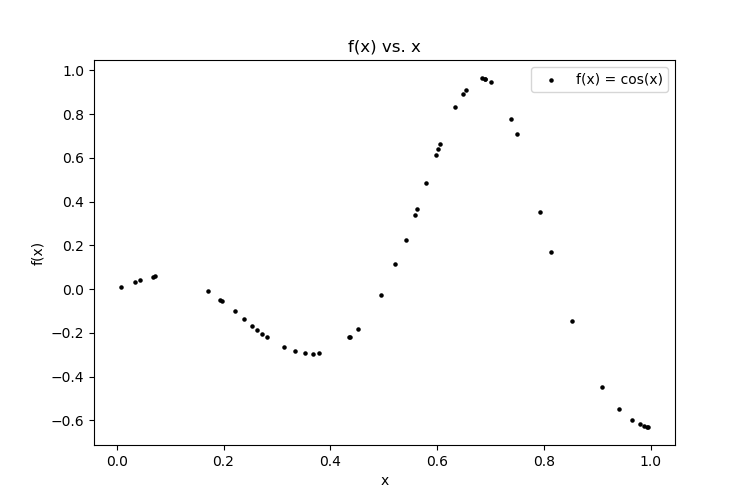

In [6]:
# plot the result
fig, axs = plt.subplots(figsize=(7.5,5),num='1D MLS example fig. 1')
axs.scatter(x,f,color='k',label='f(x) = cos(x)',s=5)
axs.set_xlabel("x")
axs.set_ylabel("f(x)")
axs.set_title("f(x) vs. x")
plt.legend()
plt.show()

In [7]:
# create approximator
app = Approximator()
k = 24

# change approximator type to RBF
app.set_approx_type('RBF')
app.set_shape(25)
app.set_k(k)

print(app)


Approximator type: Radial basis functions
Approximator parameters - k = 24
                          n = 3


Given the set of points in the grid $(x_1,\dots,x_N)$, we can construct the RBF matrix,

\begin{equation}
\mathbf{A} = \begin{bmatrix}
\varphi(||x_1 - x_1||) & \varphi(||x_1 - x_2||) & \varphi(||x_1 - x_3||) & \dots & \varphi(||x_1 - x_N||)\\
\varphi(||x_2 - x_1||) & \varphi(||x_2 - x_2||) & \varphi(||x_2 - x_3||) & \dots & \varphi(||x_2 - x_N||)\\
\vdots & \vdots & \vdots & \ddots & \vdots\\
\varphi(||x_N - x_1||) & \varphi(||x_N - x_2||) & \varphi(||x_N - x_3||) & \dots & \varphi(||x_N - x_N||)
\end{bmatrix}
\end{equation}

In [8]:
# construct the RBF matrix for the neighbors of the point i_rand
rbf_matrix = app.construct_rbf_matrix(g)

print(rbf_matrix)

dim: (50x50), type: double&
[  1.000e+00   2.177e-03   4.747e-34   ...   ...   ...    1.844e+00   5.980e-08   4.432e-11
   2.177e-03   1.000e+00   1.504e-55   ...   ...   ...    3.108e+00   7.670e-02   3.053e-24
   4.747e-34   1.504e-55   1.000e+00   ...   ...   ...    1.025e-60   2.653e-72   2.965e-07
      ...         ...         ...      ...   ...   ...       ...         ...         ...
   1.844e+00   3.108e+00   1.025e-60   ...   ...   ...    1.000e+00   2.401e+00   8.029e-107
   5.980e-08   7.670e-02   2.653e-72   ...   ...   ...    2.401e+00   1.000e+00   1.342e-35
   4.432e-11   3.053e-24   2.965e-07   ...   ...   ...    8.029e-107   1.342e-35   1.000e+00  ]


Now we need to construct the vector of function values each point in the grid,

\begin{equation}
\mathbf{f}(x) = [f(x_1),f(x_2),\dots,f(x_N)].
\end{equation}

In [9]:
# create the vector of function values for each point
v = Vector("f_vec",f)

print(v)

dim: 50, type: double&, name: 'f_vec'
[ -7.948e-03   5.786e-02   1.134e-01   ...   -6.282e-01   8.480e-03  -2.944e-01  ]


Now we wish to solve the least squares problem,

\begin{equation}
\begin{bmatrix}
\varphi(||x_1 - x_1||) & \varphi(||x_1 - x_2||)  & \dots & \varphi(||x_1 - x_N||)\\
\varphi(||x_2 - x_1||) & \varphi(||x_2 - x_2||) & \dots & \varphi(||x_2 - x_N||)\\
\vdots & \vdots  & \ddots & \vdots\\
\varphi(||x_N - x_1||) & \varphi(||x_N - x_2||)  & \dots & \varphi(||x_N - x_N||)
\end{bmatrix}\begin{bmatrix} w_1 \\ w_2 \\ \vdots \\ w_N\end{bmatrix} = \begin{bmatrix} f(x_1) \\ f(x_2) \\ \vdots \\ f(x_N)\end{bmatrix},
\end{equation}

for the weights,

\begin{equation}
\mathbf{w}(x) = [w_1,w_2,\dots,w_N].
\end{equation}

In [10]:
# solve the least squares problem Ax = y
# where y is the f_neighbors
# and x are the coefficients
w = et.dgels(rbf_matrix,v)

print(w)

dim: 50, type: double&
[  1.088e-01   4.076e-01   9.622e-02   ...    4.130e+02  -7.307e-03   3.496e-01  ]


With the weight vector $\mathbf{w}(x)$, we can compute approximate function values for any point $x$ via,

\begin{equation}
s(x) = \sum_{i=1}^{N}w_i\varphi(||x - x_i||).
\end{equation}

In [11]:
# Let's use our interpolation to find function values of a random set.
y = np.random.uniform(0,1,N)
s = []
for i in range(len(y)):
    # construct the rbf vector
    rbf_vector = app.construct_rbf_vector(g,[y[i]])
    # find the function value
    s.append(w.dot(rbf_vector))

<IPython.core.display.Javascript object>


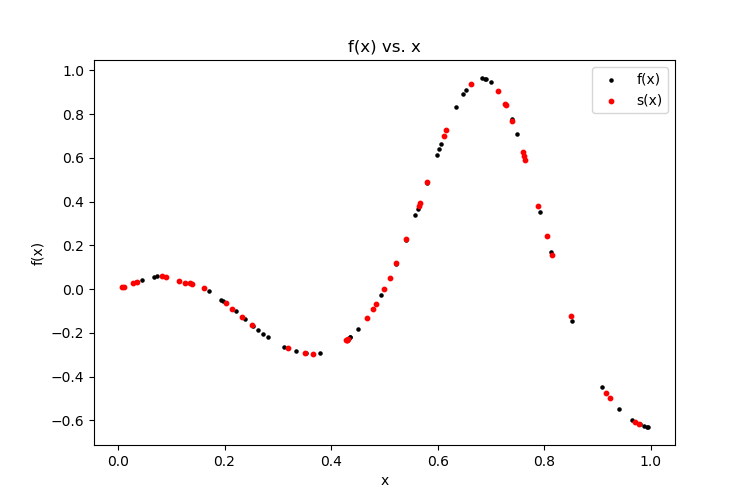

In [12]:
# let's plot these new interpolated points
fig, axs = plt.subplots(figsize=(7.5,5),num='1D MLS example fig. 2')
axs.scatter(x,f,color='k',label='f(x)',s=5)
axs.scatter(y,s,color='r',label='s(x)',s=10)
axs.set_xlabel("x")
axs.set_ylabel("f(x)")
axs.set_title("f(x) vs. x")
plt.legend()
plt.show()

In [13]:
# let's determine the error associated with the interpolation s(x)
error = [np.abs(s[i] - func(y[i]))**2]
print("Average error: %s" % np.mean(error))

Average error: 4.3578612900207407e-07


dim: 50, type: double&
[ -5.825e+13  -2.028e+14   3.420e+14   ...    2.186e+14   4.372e+13   1.295e+14  ]


<IPython.core.display.Javascript object>


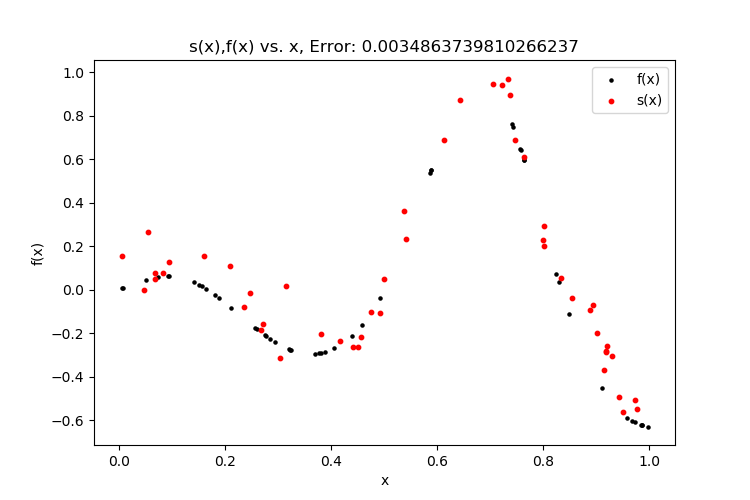

interactive(children=(FloatSlider(value=3.05, description='shape', max=9.149999999999999, min=-3.05), Output()…

In [14]:
# create a random one-dimensional grid
# between 0 and 1.
N = 50
x = np.random.uniform(0,1,N)
g = UGrid(x)
f = func(x)
shape = 3.05

# create approximator
app = Approximator()
k = N
# change approximator type to RBF
app.set_approx_type('RBF')
app.set_shape(shape)
app.set_k(k)
# construct the RBF matrix for the neighbors of the point i_rand
rbf_matrix = app.construct_rbf_matrix(g)
# create the vector of function values for each point
v = Vector("f_vec",f)
# solve the least squares problem Ax = y
# where y is the f_neighbors
# and x are the coefficients
w = et.dgels(rbf_matrix,v)
print(w)
# Let's use our interpolation to find function values of a random set.
y = np.random.uniform(0,1,N)
s = []
for i in range(len(y)):
    # construct the rbf vector
    rbf_vector = app.construct_rbf_vector(g,[y[i]])
    # find the function value
    s.append(w.dot(rbf_vector))
error = [np.abs(s[i] - func(y[i]))**2]
# let's plot these new interpolated points
fig, axs = plt.subplots(figsize=(7.5,5),num='1D MLS example fig. 3')
line1 = axs.scatter(x,f,color='k',label='f(x)',s=5)
line2 = axs.scatter(y,s,color='r',label='s(x)',s=10)
axs.set_xlabel("x")
axs.set_ylabel("f(x)")
axs.set_title("s(x),f(x) vs. x, Error: %s" % np.mean(error))
plt.legend()

def update(shape=3.05):
    app.set_shape(shape)
    rbf_matrix = app.construct_rbf_matrix(g)
    v = Vector("f_vec",f)
    w = et.dgels(rbf_matrix,v)
    s = []
    for i in range(len(y)):
        rbf_vector = app.construct_rbf_vector(g,[y[i]])
        s.append(w.dot(rbf_vector))
    line2.set_offsets(np.c_[y,s])
    error = [np.abs(s[i] - func(y[i]))**2]
    axs.set_title("s(x),f(x) vs. x, Error: %s" % np.mean(error))
    fig.canvas.draw_idle()

interact(update, index=widgets.FloatSlider(min=0, max=100.0, step=0.1, value=3.05));

In [52]:
# create a random one-dimensional grid
# between 0 and 1.
N = 50
x = np.random.uniform(0,1,N)
g = UGrid(x)
f = func(x)
# create approximator
app = Approximator()
k = 50
shape = 30
# change approximator type to RBF
app.set_approx_type('RBF')
app.set_shape(shape)
app.set_k(k)
# construct the RBF matrix 
rbf_matrix = app.construct_rbf_matrix(g)
v = Vector("f_vec",f)
w = et.dgels(rbf_matrix,v)
y = np.random.uniform(0,1,N)
s = []
for i in range(len(y)):
    # construct the rbf vector
    rbf_vector = app.construct_rbf_vector(g,[y[i]])
    # find the function value
    s.append(w.dot(rbf_vector))
# consider a random point in our grid
i_rand = np.random.randint(len(y))
y_rand, s_rand = y[i_rand], s[i_rand]

print("Random index: ",i_rand)
print("Random point: ",y_rand)
print("Random s(x):  ",s_rand)

Random index:  11
Random point:  0.9054806139533113
Random s(x):   -0.34075728767213764


<IPython.core.display.Javascript object>


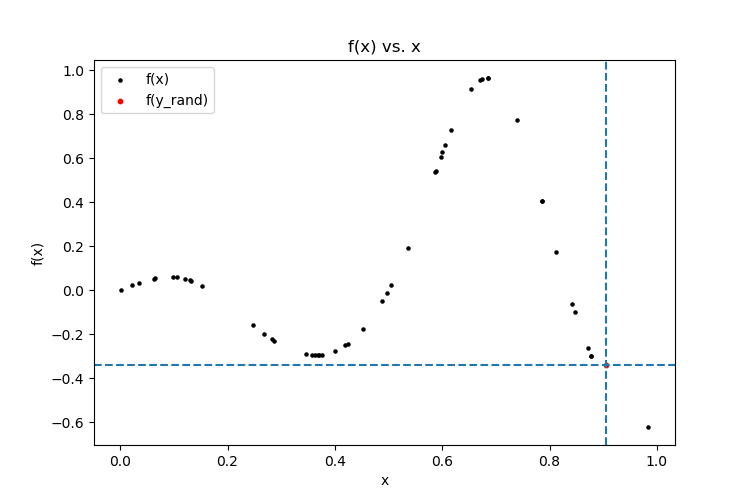

In [53]:
# lets plot that point
fig, axs = plt.subplots(figsize=(7.5,5),num='1D MLS example fig. 5')
axs.scatter(x,f,color='k',label='f(x)',s=5)
axs.scatter(y_rand,s_rand,color='r',label='f(y_rand)',s=10)
axs.axhline(s_rand,linestyle='--')
axs.axvline(y_rand,linestyle='--')
axs.set_xlabel("x")
axs.set_ylabel("f(x)")
axs.set_title("f(x) vs. x")
plt.legend()
plt.show()

In [54]:
# to compute the derivative at this point, we simply use the 
# weight vector w(x) multiplied by the derivative of the 
# rbf matrix
rbfd_vector = app.construct_rbfd_vector(g,[y_rand])
print(rbfd_vector)
print(w)
f_der = -w.dot(rbfd_vector)


print(f_der)

dim: 50, type: double&
[  2.620e-24   3.802e+00   2.303e-64   ...    2.657e-32   2.580e-79   7.475e+00  ]
dim: 50, type: double&
[  1.993e+00  -2.451e-02   1.921e-01   ...   -3.483e+00  -7.368e-02   1.259e+00  ]
0.1720204074283025


<IPython.core.display.Javascript object>


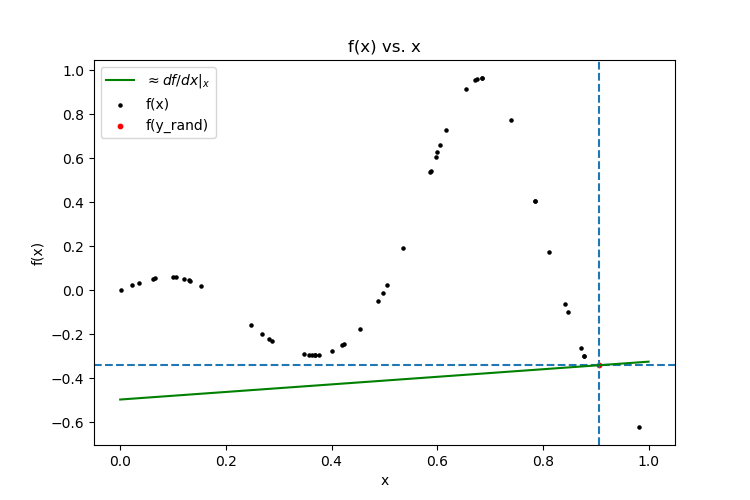

In [55]:
# let's find the tangent line and plot it
f_0 = -f_der*y_rand + s_rand
f_d = f_der
x_lin = np.linspace(0,1,50)
tangent = f_d*x_lin + f_0

# lets plot that point
fig, axs = plt.subplots(figsize=(7.5,5),num='1D MLS example fig. 6')
axs.scatter(x,f,color='k',label='f(x)',s=5)
axs.scatter(y_rand,s_rand,color='r',label='f(y_rand)',s=10)
axs.axhline(s_rand,linestyle='--')
axs.axvline(y_rand,linestyle='--')
axs.plot(x_lin,tangent,color='g',label=r'$\approx df/dx|_{x}$')
axs.set_xlabel("x")
axs.set_ylabel("f(x)")
axs.set_title("f(x) vs. x")
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


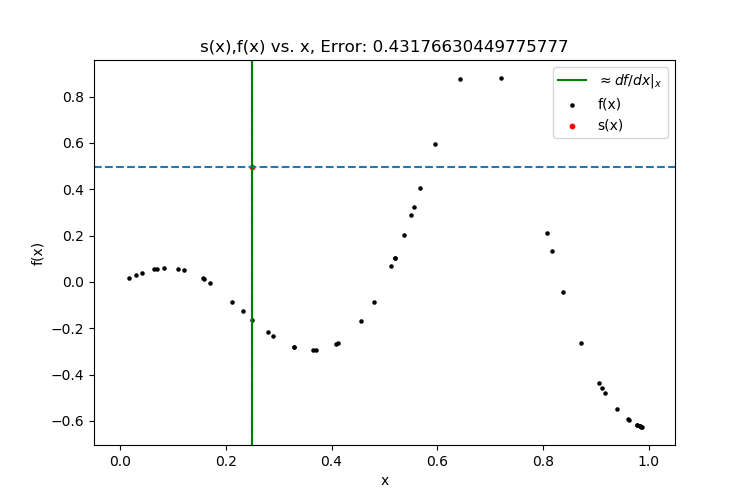

interactive(children=(FloatSlider(value=3.05, description='shape', max=9.149999999999999, min=-3.05), FloatSli…

In [38]:
# Let's see how this works at random points
# create a random one-dimensional grid
# between 0 and 1.
N = 50
x = np.random.uniform(0,1,N)
g = UGrid(x)
f = func(x)
shape = 3.05

i_rand = np.random.randint(len(y))
y_rand, f_rand = y[i_rand], s[i_rand]

# create approximator
app = Approximator()
k = N
# change approximator type to RBF
app.set_approx_type('RBF')
app.set_shape(shape)
app.set_k(k)
# construct the RBF matrix for the neighbors of the point i_rand
rbf_matrix = app.construct_rbf_matrix(g)
# create the vector of function values for each point
v = Vector("f_vec",f)
# solve the least squares problem Ax = y
# where y is the f_neighbors
# and x are the coefficients
w = et.dgels(rbf_matrix,v)
# Let's use our interpolation to find function values of a random set.
i_rand = np.random.randint(len(y))
y_rand = y[i_rand]
rbf_vector = app.construct_rbf_vector(g,[y_rand])
# find the function value
s_rand = w.dot(rbf_vector)
error = np.abs(s_rand - func(y_rand))**2
f_0 = -f_der*y_rand + s[i_rand]
f_d = f_der
x_lin = np.linspace(0,1,50)
tangent = f_d*x_lin + f_0
# let's plot these new interpolated points
fig, axs = plt.subplots(figsize=(7.5,5),num='1D MLS example fig. 7')
line1 = axs.scatter(x,f,color='k',label='f(x)',s=5)
line2 = axs.scatter(y_rand,s_rand,color='r',label='s(x)',s=10)
line4 = axs.axhline(s_rand,linestyle='--')
line5 = axs.axvline(y_rand,linestyle='--')
line6, = axs.plot(x_lin,tangent,color='g',label=r'$\approx df/dx|_{x}$')
axs.set_xlabel("x")
axs.set_ylabel("f(x)")
axs.set_title("s(x),f(x) vs. x, Error: %s" % error)
plt.legend()

def update(shape=3.05,y=0.5):
    app.set_shape(shape)
    rbf_matrix = app.construct_rbf_matrix(g)
    v = Vector("f_vec",f)
    w = et.dgels(rbf_matrix,v)
    rbfd_vector = app.construct_rbfd_vector(g,[y])
    s = w.dot(rbf_vector)
    f_der = w.dot(rbfd_vector)
    f_0 = -f_der*y + s
    f_d = f_der
    x_lin = np.linspace(0,1,50)
    tangent = f_d*x_lin + f_0
    line2.set_offsets(np.c_[y,s])
    line4.set_ydata(s)
    line5.set_data(y,[0,1])
    line6.set_ydata(tangent)
    error = np.abs(s - func(y))**2
    axs.set_title("s(x),f(x) vs. x, Error: %s" % error)
    fig.canvas.draw_idle()

interact(update, index=widgets.FloatSlider(min=0, max=100.0, step=0.1, value=3.05),
        y=widgets.FloatSlider(min=0, max=1.0, step=.05, value=0));

In [36]:
# grab the x and f values for those neighbors
x_neighbors = [x[i] for i in neighbors]
f_neighbors = [f[i] for i in neighbors]

print("x values for the %s nearest neighbors to the point %s:" % (k,x_rand))
print(x_neighbors)
print("f(x) values for the %s nearest neighbors to the point %s:" % (k,x_rand))
print(f_neighbors)

x values for the 10 nearest neighbors to the point 0.8738536154791952:
[0.8738536154791952, 0.8974513445004559, 0.8483927532803324, 0.8426638106140086, 0.8425432552441866, 0.919023203569624, 0.8221748117640982, 0.7454192226743994, 0.6384090941094819, 0.6228035328091256]
f(x) values for the 10 nearest neighbors to the point 0.8738536154791952:
[-0.2779545276609857, -0.39945517418230014, -0.11308838113767883, -0.07133427674205228, -0.07043838801223268, -0.4852732439718228, 0.09013988554888708, 0.7321246449057028, 0.8513264001529706, 0.7688659698424933]


<IPython.core.display.Javascript object>


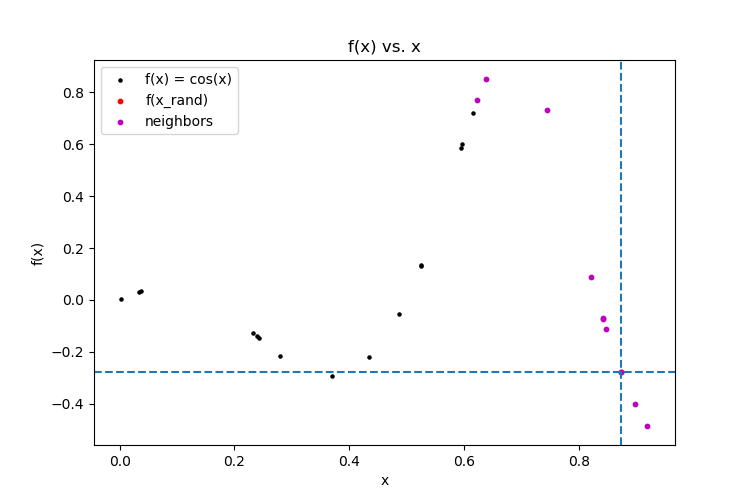

In [37]:
# plot the result
fig, axs = plt.subplots(figsize=(7.5,5),num='1D MLS example fig. 3')
axs.scatter(x,f,color='k',label='f(x) = cos(x)',s=5)
axs.scatter(x_rand,f_rand,color='r',label='f(x_rand)',s=10)
axs.scatter(x_neighbors,f_neighbors,color='m',label='neighbors',s=10)
axs.axhline(f_rand,linestyle='--')
axs.axvline(x_rand,linestyle='--')
axs.set_xlabel("x")
axs.set_ylabel("f(x)")
axs.set_title("f(x) vs. x")
plt.legend()
plt.show()

In [38]:
# now we can construct a derivative matrix for the set of points
# in neighbors
rbfd_matrix = app.construct_rbfd_matrix(g,neighbors,i_rand)

print(rbfd_matrix)

dim: (10x10), type: double&
[  -0.000e+00  -1.432e-01  -1.544e-01   ...   ...   ...   -6.721e-01  -8.576e-01  -8.520e-01
  -1.432e-01   -0.000e+00  -2.927e-01   ...   ...   ...   -7.480e-01  -8.464e-01  -8.305e-01
  -1.544e-01  -2.927e-01   -0.000e+00   ...   ...   ...   -5.692e-01  -8.499e-01  -8.571e-01
      ...         ...         ...      ...   ...   ...       ...         ...         ...
  -6.721e-01  -7.480e-01  -5.692e-01   ...   ...   ...    -0.000e+00  -5.869e-01  -6.504e-01
  -8.576e-01  -8.464e-01  -8.499e-01   ...   ...   ...   -5.869e-01   -0.000e+00  -9.499e-02
  -8.520e-01  -8.305e-01  -8.571e-01   ...   ...   ...   -6.504e-01  -9.499e-02   -0.000e+00  ]


In [39]:
# From here, the first derivative at each point in the
# neighborhood is given by
fd_app = et.dgemv(1.0,rbfd_matrix,f_app)

print(fd_app)

dim: 25, type: double&, name: '1.000000 *   *  '
[  1.312e-01   1.165e-01   1.952e-01   ...    0.000e+00   0.000e+00   0.000e+00  ]


In [40]:
# the first derivative of the point of interest
# is the first entry

# the y-intercept of the tangent vector is
f_0 = -fd_app[0]*x_rand + f_rand
# while the slope is
f_1 = fd_app[0]

print("The tangent vector of f(x) at %s is:" % x_rand)
print("<x, %.2f*x + %.2f>" % (f_1,f_0))

The tangent vector of f(x) at 0.8738536154791952 is:
<x, 0.13*x + -0.39>


<IPython.core.display.Javascript object>


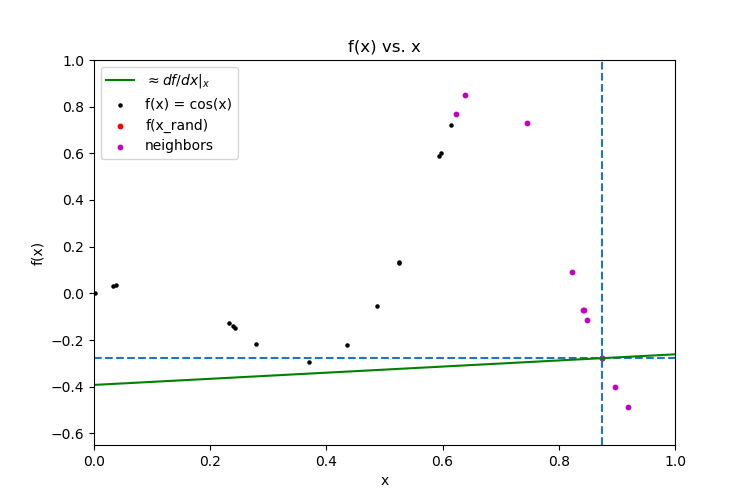

In [41]:
# generate a set of points for the line
x_lin = np.asarray([-np.pi,np.pi])
tangent = f_1*x_lin + f_0
# now to plot it with the neighbors
fig, axs = plt.subplots(figsize=(7.5,5),num='1D MLS example fig. 4')
axs.scatter(x,f,color='k',label='f(x) = cos(x)',s=5)
axs.scatter(x_rand,f_rand,color='r',label='f(x_rand)',s=10)
axs.scatter(x_neighbors,f_neighbors,color='m',label='neighbors',s=10)
axs.axhline(f_rand,linestyle='--')
axs.axvline(x_rand,linestyle='--')
axs.plot(x_lin,tangent,color='g',label=r'$\approx df/dx|_{x}$')
axs.set_xlabel("x")
axs.set_ylabel("f(x)")
axs.set_title("f(x) vs. x")
axs.set_xlim(0,1)
axs.set_ylim(-.65,1.0)
plt.legend()
plt.show()